# Implementing a CNNGAN with tensorflow

## 1. Import and Preprocessing
### a) Importing modules

In [1]:
# Load required packages - data handling & plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load required packages - deep learning 
import tensorflow as tf
from tensorflow import keras

In [2]:
print(f"tensorflow: {tf.__version__}")
import sys
print(f"python: {sys.version[:5]}")

tensorflow: 2.4.1
python: 3.7.5


### b) Importing the data

In [3]:
#download and save to file
#urllib.request.urlretrieve(
#    "https://media.githubusercontent.com/media/mmeierer/CNN---TensorFlow-vs-PyTorch/main/fashion-mnist_train.csv",
#    "fashion-mnist_train2.csv")

In [4]:
train_data = pd.read_csv('fashion-mnist_train.csv')
# test_data = pd.read_csv('fashion-mnist_test.csv') # test data not used for gan

In [5]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train_images = train_data.iloc[:,1:]

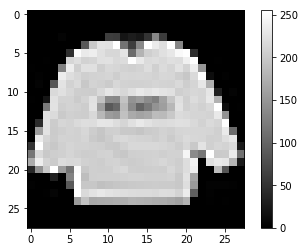

In [7]:
plt.figure()
plt.imshow(train_images.values[0].reshape(28,28), cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

### c) Data preparation

In [8]:
#np.unique(train_labels) # no classification tasked performed

In [9]:
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [10]:
# use maximum normalization
train_images = train_images / np.float32(255)
#test_images = test_images / np.float32(255)

In [11]:
train_images.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.019608,0.0,0.0,...,0.000000,0.0,0.0,0.117647,0.168627,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.003922,0.007843,0.0,0.0,0.000000,0.0,0.0,...,0.011765,0.0,0.0,0.000000,0.000000,0.003922,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0



## 2. Model specific data preparation (tensorflow)
## a) Load the data

In [12]:
x_train_tf = tf.convert_to_tensor(train_images.values.reshape((-1, 28, 28, 1)))

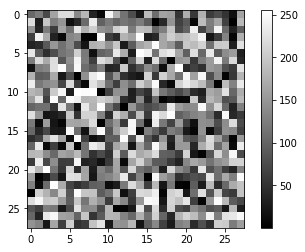

In [13]:
# use random seed to create fake input data
seed = tf.random.uniform([28,28], 0, 1, tf.float32)
seed_im = seed.numpy() * 255
plt.figure()
plt.imshow(seed_im, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

### b) Tensor view of the data

In [14]:
x_train_tf.shape

TensorShape([60000, 28, 28, 1])

In [15]:
seed.shape

TensorShape([28, 28])

In [1]:
x_train_tf[0][5]

NameError: name 'x_train_tf' is not defined

## 3. Model definition

### a.1) Generator

In [65]:
# for weight initialization
initializer_nn = tf.random_uniform_initializer(minval=-1, maxval=1, seed=123)
def generator_model():   
    model = tf.keras.Sequential()
    model.add(keras.layers.Conv2DTranspose(64, (7,7), input_shape=(1,1, 100,), strides=1, padding='valid', use_bias=True, name="Conv2D1"))
    model.add(keras.layers.BatchNormalization(name="Batchnorm1"))
    model.add(keras.layers.LeakyReLU(name="LeakyRelu1"))

    #model.add(keras.layers.Reshape((7, 7, 64)))
    assert model.output_shape == (None, 7, 7, 64)

    model.add(keras.layers.Conv2DTranspose(64, (8, 8), strides=(1, 1), padding='valid', use_bias=True, name="Conv2D2"))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(keras.layers.BatchNormalization(name="Batchnorm2"))
    model.add(keras.layers.LeakyReLU(name="LeakyRelu2"))

    model.add(keras.layers.Conv2DTranspose(1, (15, 15), strides=(1, 1), padding='valid', use_bias=True, name="Conv2D3"))
    model.add(keras.layers.Activation(keras.activations.sigmoid, name="Sigmoid1"))
    assert model.output_shape == (None, 28, 28, 1)

    return model
generator = generator_model()

In [64]:
# generated image not trained
fake_im_not_trained = generator(tf.random.normal([1, 1, 1, 100], 0, 1, tf.float32))
fake_im_not_trained.shape

###  a.2) Inspect the generator model

In [62]:
generator.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_28 (Conv2DT (None, 7, 7, 64)          313664    
_________________________________________________________________
batch_normalization_19 (Batc (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_29 (Conv2DT (None, 14, 14, 64)        262208    
_________________________________________________________________
batch_normalization_20 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_30 (Conv2DT (None, 28, 28, 1)       

### a.3) Inspect the first convolutional layer

In [22]:
hidden1_tf_ante = generator.layers[4]
weights_tf_ante, biases_tf_ante = hidden1_tf_ante.get_weights()
weights_tf_ante[0]

array([[[-2.6862690e-02,  3.7791885e-02, -4.5578554e-04, ...,
          1.6367149e-02,  3.8238131e-03, -1.5901491e-02],
        [-3.3726726e-02,  2.7743965e-02, -1.4282478e-02, ...,
          3.2309018e-02,  4.2973511e-02, -1.3382064e-02],
        [-1.5638636e-02, -2.8354175e-02,  4.1597210e-02, ...,
         -3.6292434e-02,  2.6293665e-02, -2.5772661e-02],
        ...,
        [ 2.6091792e-02, -3.8270965e-02, -1.8405339e-02, ...,
         -1.0119107e-02,  2.6020184e-02,  1.9093804e-02],
        [-3.1314395e-02, -1.5727360e-02,  3.8183264e-02, ...,
          1.3798282e-02,  1.4307212e-02, -1.1190511e-02],
        [-1.3778964e-02, -3.6731176e-02, -2.3476940e-02, ...,
          2.9018298e-02,  1.6734801e-02, -2.8163381e-02]],

       [[-9.6410178e-03, -3.8852442e-02,  2.4213888e-02, ...,
         -3.1392962e-02, -2.2196352e-02, -3.4429386e-02],
        [-4.3017313e-02, -3.9663732e-02, -1.9694218e-02, ...,
          4.2742275e-02, -3.8809124e-02,  4.0499665e-02],
        [ 2.2598617e-02, 

In [23]:
weights_tf_ante[0].shape

(5, 64, 64)

In [24]:
biases_tf_ante.shape

(64,)

### b.1) Discriminator

In [76]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Conv2D(input_shape=(28,28,1), filters=2, kernel_size=5, strides=1, padding="same", name="Conv2D1"))
    model.add(keras.layers.AveragePooling2D(pool_size=2, strides=2, name="Pooling1"))
    model.add(keras.layers.LeakyReLU(name="LeakyRelu1"))
    model.add(keras.layers.Dropout(0.3, name="Dropout1"))
    
    model.add(keras.layers.Conv2D(filters=2, kernel_size=5, strides=1, padding="same", name="Conv2D2"))
    model.add(keras.layers.LeakyReLU(name="LeakyRelu2"))
    
    model.add(keras.layers.Conv2D(filters=1, kernel_size=5, strides=1, name="conv2D3"))
    model.add(keras.layers.LeakyReLU(name="LeakyRelu3"))
    
    model.add(keras.layers.Flatten(name="Flatten1"))
    
    model.add(keras.layers.Dense(100, kernel_initializer=initializer_nn, name="Dense1"))
    model.add(keras.layers.LeakyReLU(name="LeakyRelu4"))
    
    model.add(keras.layers.Dense(64, kernel_initializer=initializer_nn, name="Dense2"))
    model.add(keras.layers.Activation(keras.activations.tanh, name="Tanh"))
    
    model.add(keras.layers.Dense(1, kernel_initializer=initializer_nn, name="Dense3"))
    model.add(keras.layers.Activation(keras.activations.sigmoid, name="Sigmoid"))
    return model
discriminator = discriminator_model()

### b.2) Inspect the discriminator model

In [77]:
discriminator.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D1 (Conv2D)             (None, 28, 28, 2)         52        
_________________________________________________________________
Pooling1 (AveragePooling2D)  (None, 14, 14, 2)         0         
_________________________________________________________________
LeakyRelu1 (LeakyReLU)       (None, 14, 14, 2)         0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 14, 14, 2)         0         
_________________________________________________________________
Conv2D2 (Conv2D)             (None, 14, 14, 2)         102       
_________________________________________________________________
LeakyRelu2 (LeakyReLU)       (None, 14, 14, 2)         0         
_________________________________________________________________
conv2D3 (Conv2D)             (None, 10, 10, 1)       

### b.3) Inspect the first convolutional layer

In [27]:
hidden2_tf_ante = discriminator.layers[0]
weights2_tf_ante, biases2_tf_ante = hidden2_tf_ante.get_weights()
weights2_tf_ante[0]

array([[[-0.19798169,  0.19620275]],

       [[ 0.13163957,  0.20191011]],

       [[ 0.01896393, -0.13886672]],

       [[ 0.0740841 ,  0.21428794]],

       [[-0.17835097, -0.04407401]]], dtype=float32)

In [28]:
biases2_tf_ante

array([0., 0.], dtype=float32)

## 4. Loss & Optimizer

### 4.a) Generator loss

In [29]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits='activation')
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### 4.b) Discriminator loss

In [30]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

## 4.c) Optimizers

In [31]:
generator_optimizer = tf.keras.optimizers.Adam(1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy') # only for discriminator

In [32]:
#seed2 = tf.random.uniform([1, 28,28, 1], 0, 1, tf.float32)
#print(np.unique(seed2.numpy()))
#print(seed2)
#fake_im = generator(seed2, training=False)
#print(fake_im)
#f = discriminator(seed2)
#print(generator_loss(fake_im))
#print(f)

## 5. Training

In [33]:
# for saving the model
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [34]:
# This annotation causes the function to be "compiled".
#@tf.function
def train_step_tf(generator, discriminator, generator_optimizer, discriminator_optimizer, batch_size = 100):
    gen_losses = []
    disc_losses = []
    for beg_i in range(0, x_train_tf.shape[0], batch_size):
        x_train_batch_tf = x_train_tf[beg_i:beg_i + batch_size]
        #y_train_batch_tf = y_train_tf[beg_i:beg_i + batch_size]

        x_fake_batch_tf = tf.random.uniform([batch_size, 100], 0, 1, tf.float32)

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

            generated_images = generator( x_fake_batch_tf, training=True)
            real_output = discriminator(x_train_batch_tf, training=True)
            fake_output = discriminator(generated_images, training=True)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        gen_losses.append(gen_loss)
        disc_losses.append(disc_loss)
        train_accuracy.update_state(tf.ones_like(real_output), real_output)
        train_accuracy.update_state(tf.zeros_like(fake_output), fake_output)
    return gen_losses, disc_losses

In [35]:
train_losses_generator_tf = []
train_losses_discriminator_tf = []
#test_loss_tf = []

train_acc_discriminator_tf = []
#test_acc_tf = []

epochs = 15

for epoch in range(epochs):
    gen_loss, disc_loss = train_step_tf(generator, discriminator, generator_optimizer, discriminator_optimizer)
    train_loss_generator_tf = float(tf.reduce_mean(gen_loss))
    train_loss_discriminator_tf = float(tf.reduce_mean(disc_loss))
    train_losses_generator_tf.append(train_loss_generator_tf)
    train_losses_discriminator_tf.append(train_loss_discriminator_tf)

    template = ("Epoch {}, Loss_Generator: {}, Loss_Discriminator: {}, Discriminator_Accuracy: {}")
    print(template.format(epoch+1, train_loss_generator_tf, train_loss_discriminator_tf, train_accuracy.result()*100))
  
    # save model every 5th epoch
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)
    train_acc_discriminator_tf.append(train_accuracy.result()*100)

    train_accuracy.reset_states()

Epoch 1, Loss_Generator: 1.1340556144714355, Loss_Discriminator: 1.339301586151123, Discriminator_Accuracy: 66.28999328613281
Epoch 2, Loss_Generator: 3.217888593673706, Loss_Discriminator: 0.42261064052581787, Discriminator_Accuracy: 91.44916534423828
Epoch 3, Loss_Generator: 1.6300679445266724, Loss_Discriminator: 0.8643975853919983, Discriminator_Accuracy: 80.9124984741211
Epoch 4, Loss_Generator: 1.1133203506469727, Loss_Discriminator: 1.1608394384384155, Discriminator_Accuracy: 68.17583465576172
Epoch 5, Loss_Generator: 0.9983875751495361, Loss_Discriminator: 1.2210521697998047, Discriminator_Accuracy: 67.66666412353516
Epoch 6, Loss_Generator: 1.0006558895111084, Loss_Discriminator: 1.153459072113037, Discriminator_Accuracy: 70.26000213623047
Epoch 7, Loss_Generator: 1.3782352209091187, Loss_Discriminator: 0.9755181074142456, Discriminator_Accuracy: 77.12332916259766
Epoch 8, Loss_Generator: 1.475033164024353, Loss_Discriminator: 0.9159044623374939, Discriminator_Accuracy: 78.581

### b) Training progress

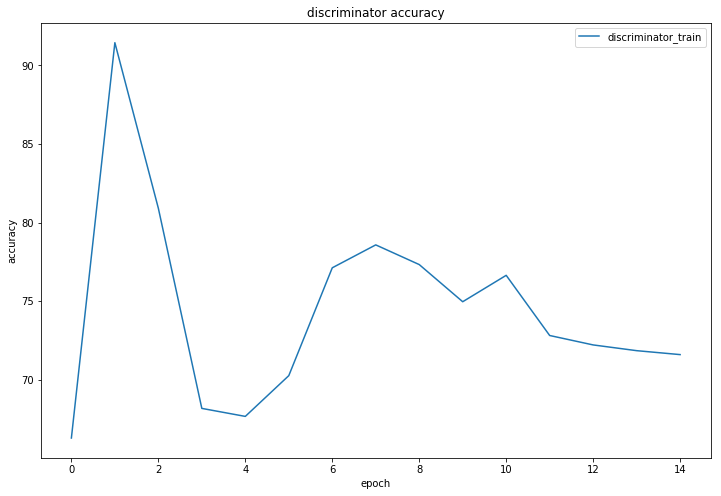

In [36]:
plt.figure(figsize=(12,8))
plt.plot(train_acc_discriminator_tf)
plt.title('discriminator accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['discriminator_train'], loc='upper right')
plt.show()

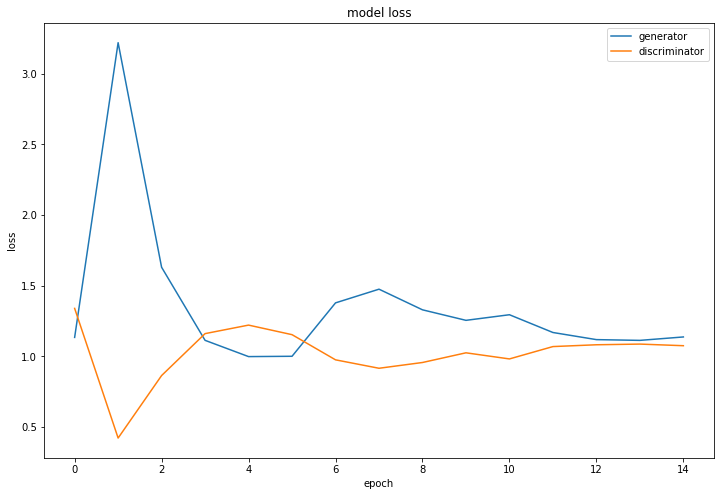

In [37]:
plt.figure(figsize=(12,8))
plt.plot(train_losses_generator_tf)
plt.plot(train_losses_discriminator_tf)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['generator', 'discriminator'], loc='upper right')
plt.show()

In [38]:
print(train_losses_generator_tf)
print(train_losses_discriminator_tf)

[1.1340556144714355, 3.217888593673706, 1.6300679445266724, 1.1133203506469727, 0.9983875751495361, 1.0006558895111084, 1.3782352209091187, 1.475033164024353, 1.3291462659835815, 1.2547729015350342, 1.2943683862686157, 1.1687989234924316, 1.1184277534484863, 1.1131075620651245, 1.137269139289856]
[1.339301586151123, 0.42261064052581787, 0.8643975853919983, 1.1608394384384155, 1.2210521697998047, 1.153459072113037, 0.9755181074142456, 0.9159044623374939, 0.9566524028778076, 1.0251482725143433, 0.9819122552871704, 1.0692600011825562, 1.0820579528808594, 1.086851954460144, 1.0753918886184692]


### c1) Generator output before training

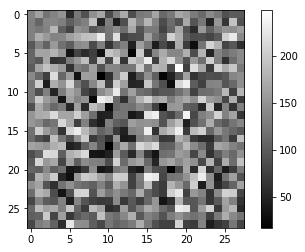

In [39]:
fake_im_not_trained = fake_im_not_trained.numpy() * 255
fake_im_not_trained = fake_im_not_trained.reshape((28,28))
plt.figure()
plt.imshow(fake_im_not_trained, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

### c2) Generator output after training

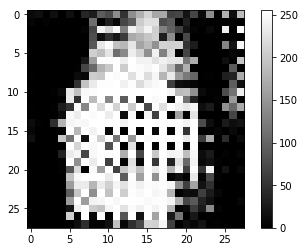

In [40]:
seed2 = tf.random.uniform([1, 100], 0, 1, tf.float32)
fake_im = generator(seed2, training=False)
fake_im = fake_im.numpy() * 255
fake_im = fake_im.reshape((28,28))
plt.figure()
plt.imshow(fake_im, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()